# Train a `biolord` model over human cell atlas of fetal chromatin accessibility

We apply `biolord` to study the cell atlas of fetal chromatin accessibility[[1]](https://www.science.org/doi/10.1126/science.aba7612).
This notebook relies on pre-processed data obatained in `1_atac-tissue-age-celltype_preprocessing.ipynb`. <br>
Alternatively the adata can be downloaded from figshare, [`atac_biolord.h5ad`]().

Here we train a `biolord` model on the spatio-temporally resolved single cell atlas of the Plasmodium liver stage[[1]](https://www.nature.com/articles/s41586-022-05406-5) to recover gene expression trends associated with infected state.

[[1] Domcke, S., Hill, A.J., Daza, R.M., Cao, J., O’Day, D.R., Pliner, H.A., Aldinger, K.A., Pokholok, D., Zhang, F., Milbank, J.H. and Zager, M.A., 2020. A human cell atlas of fetal chromatin accessibility. Science, 370(6518), p.eaba7612.](https://www.science.org/doi/10.1126/science.aba7612)

## load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
from numba import NumbaDeprecationWarning
warnings.simplefilter("ignore", NumbaDeprecationWarning)

In [3]:
import os
import sys
import scanpy as sc
from muon import atac as ac
import anndata

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

import biolord

In [5]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR, OUTPUT_DIR

## Set parameters

In [6]:
import mplscience

mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

In [7]:
DATA_DIR_LCL = str(DATA_DIR) + "/atac-tissue-age-celltype/"
OUTPUT_DIR_LCL = str(OUTPUT_DIR) + "/atac-tissue-age-celltype/"
FIG_DIR_LCL = str(FIG_DIR) +  "/atac-tissue-age-celltype/"

## Import pre-processed adata

In [8]:
atac = sc.read(
    DATA_DIR_LCL + "adata_atac.h5ad",
    backup_url="https://figshare.com/articles/dataset/atac-tissue-age-celltype/23702631",
)

## Train a `biolord` model

We start by setting the `adata` object

In [ ]:
biolord.Biolord.setup_anndata(
    atac,
    ordered_attributes_keys=["day_of_pregnancy"],
    categorical_attributes_keys=["tissue", "cell_type"],
    retrieval_attribute_key=None,
    layer="counts"
)

### Set the model

In [ ]:
module_params = {
    "decoder_width": 512,
    "decoder_depth": 6,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "use_batch_norm": False,
    "use_layer_norm": False,
    "unknown_attribute_noise_param": 1e0,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 16,
    "gene_likelihood": "poisson",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e0,
    "attribute_dropout_rate": 0.1,
    "eval_r2_ordered": False
}

In [ ]:
model = biolord.Biolord(
    adata=atac,
    n_latent=128,
    model_name="atac_tissue_ct_time_cont_counts_poisson",
    module_params=module_params,
    train_classifiers=False,
    split_key="split_random",
)

In [ ]:
trainer_params = {
    "n_epochs_warmup": 0,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}

In [ ]:
import torch
torch.set_float32_matmul_precision('high')
model.train(
    max_epochs=100,
    batch_size=1024,
    plan_kwargs=trainer_params,
    early_stopping=False,
    enable_checkpointing=False,
    early_stopping_patience=20,
    check_val_every_n_epoch=10,
    num_workers=1,
)

In [ ]:
model.save(dir_path=OUTPUT_DIR_LCL + f"{model.model_name}_model/", overwrite=True)

## Analyze results

### Load model

In [9]:
biolord.Biolord.setup_anndata(
    atac,
    ordered_attributes_keys=["day_of_pregnancy"],
    categorical_attributes_keys=["tissue", "cell_type"],
    retrieval_attribute_key=None,
    layer="counts"
)

In [10]:
model_name="atac_tissue_ct_time_cont_counts_poisson"
model = biolord.Biolord.load(
    dir_path = OUTPUT_DIR_LCL + f"{model_name}_model/",
    adata = atac
)

INFO     File                                                                                                      
         /cs/labs/mornitzan/zoe.piran/research/projects/biolord_data/output/atac-tissue-age-celltype/atac_tissue_ct
         _time_cont_counts_poisson_model/model.pt already downloaded                                               


[rank: 0] Global seed set to 42


### Visualize latent space

In [11]:
attribute_keys_categorical = ["tissue", "cell_type"]
attribute_keys_continuous = ["day_of_pregnancy"]
attribute_keys = [*attribute_keys_categorical, *attribute_keys_continuous]
attribute_keys

['tissue', 'cell_type', 'day_of_pregnancy']

In [12]:
# Get embeddings
transf_embeddings_attributes = {}
for attribute_ in attribute_keys_categorical:
    transf_embeddings_attributes[attribute_] = sc.pp.scale(model.get_categorical_attribute_embeddings(attribute_key=attribute_))

for attribute_ in attribute_keys_continuous:
    transf_embeddings_attributes[attribute_] = sc.pp.scale(model.get_ordered_attribute_embedding(
        attribute_key=attribute_, 
        vals=np.sort(atac.obs[attribute_].unique())[:, np.newaxis]
    ))

attribute_model_keys = {}
attribute_model_keys_maps = {}
for attribute_ in attribute_keys_categorical:
    attribute_model_keys[attribute_] = list(model.categorical_attributes_map[attribute_].keys())
    attribute_model_keys_maps[attribute_] = model.categorical_attributes_map[attribute_]

for attribute_ in attribute_keys_continuous:
    cats = list(np.sort(atac.obs[attribute_].unique()))
    attribute_model_keys[attribute_] = cats
    attribute_model_keys_maps[attribute_] = {cat: i for i, cat in enumerate(cats)} 


keys = list(itertools.product(*[attribute_model_keys[attribute_] for attribute_ in attribute_keys]))

transf_embeddings_attributes_dict = {
    "_".join([str(k) for k in key_]): np.concatenate((
        [
            transf_embeddings_attributes[attribute_][attribute_model_keys_maps[attribute_][key_[ai]], :] for ai, attribute_ in enumerate(attribute_keys)
        ]
    ), 0)  
    for key_ in keys 
}


transf_embeddings_attributes = [
    np.concatenate((
[
            transf_embeddings_attributes[attribute_][attribute_model_keys_maps[attribute_][key_[ai]], :] for ai, attribute_ in enumerate(attribute_keys)
        ]
    ), 0)  
    for key_ in keys
]

In [13]:
attr = np.asarray(transf_embeddings_attributes)

In [14]:
adata_emb = anndata.AnnData(X=attr, dtype=attr.dtype)
adata_emb.obs_names = ["_".join([str(k) for k in key]) for key in keys]
adata_emb.obs["tissue"] = [key[0] for key in keys]
adata_emb.obs["cell_type"] = [key[1] for key in keys]
adata_emb.obs["day_of_pregnancy"] = [key[2] for key in keys]
adata_emb

AnnData object with n_obs × n_vars = 10530 × 48
    obs: 'tissue', 'cell_type', 'day_of_pregnancy'

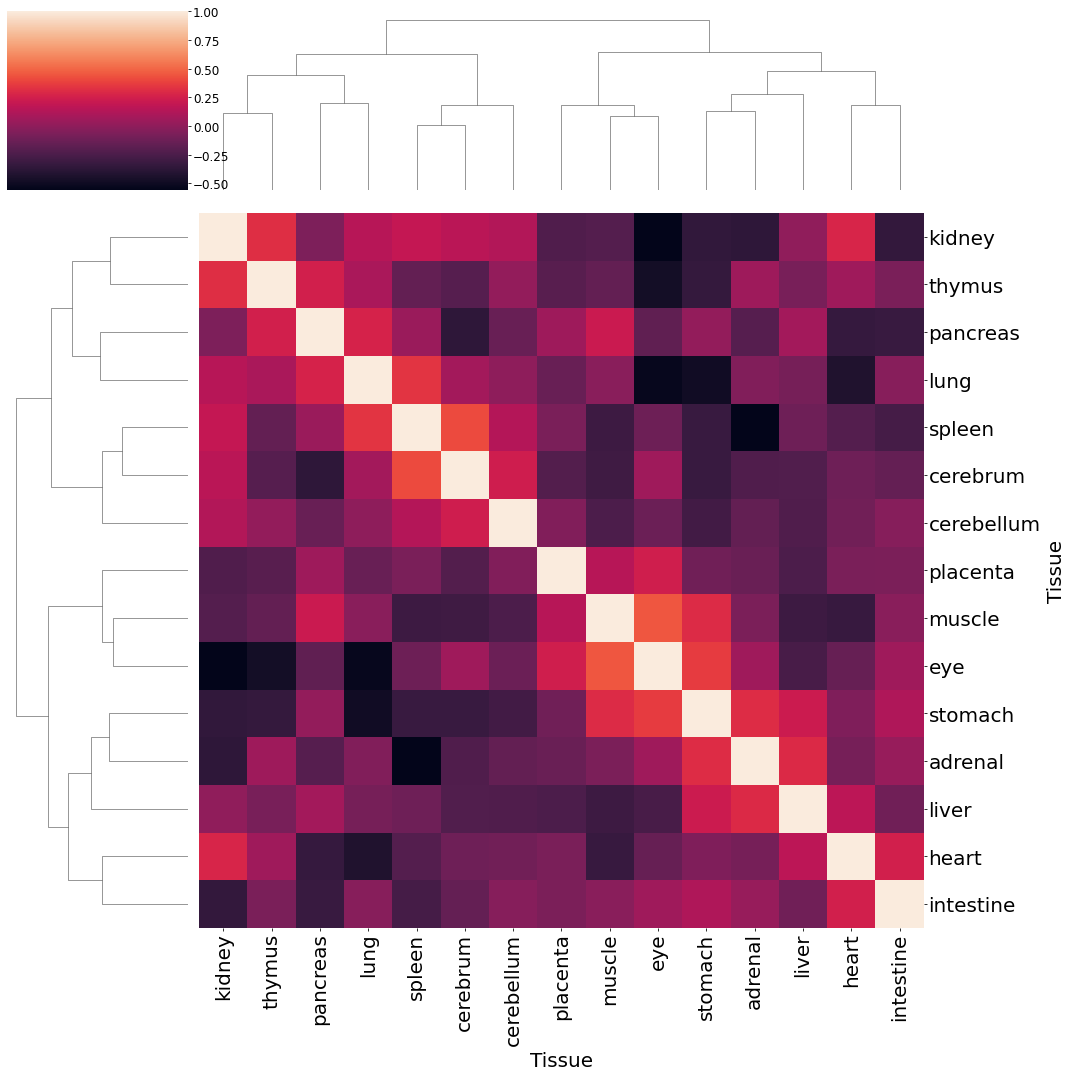

In [15]:
df = pd.DataFrame(attr, index=adata_emb.obs_names)
df = df.iloc[:, :16]
df["tissue"] = [key[0] for key in keys]
# df["cell_type"] = [key[1] for key in keys]
# df["day_of_pregnancy"] = [key[2] for key in keys]
df_agg = df.groupby("tissue").mean().T
linkage = hc.linkage(df_agg.corr(), method='complete', optimal_ordering=True)
h = sns.clustermap(df_agg.corr(), row_linkage=linkage, col_linkage=linkage, yticklabels=1, xticklabels=1, figsize=(15, 15))
h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_yticklabels(), rotation=0, fontsize=20)
h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xticklabels(), rotation=90, fontsize=20)
h.ax_heatmap.set_ylabel("Tissue", fontsize=20)
h.ax_heatmap.set_xlabel("Tissue", fontsize=20)
plt.savefig(
        FIG_DIR_LCL + "embedding_cluster_tissue.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
plt.tight_layout()
plt.show()

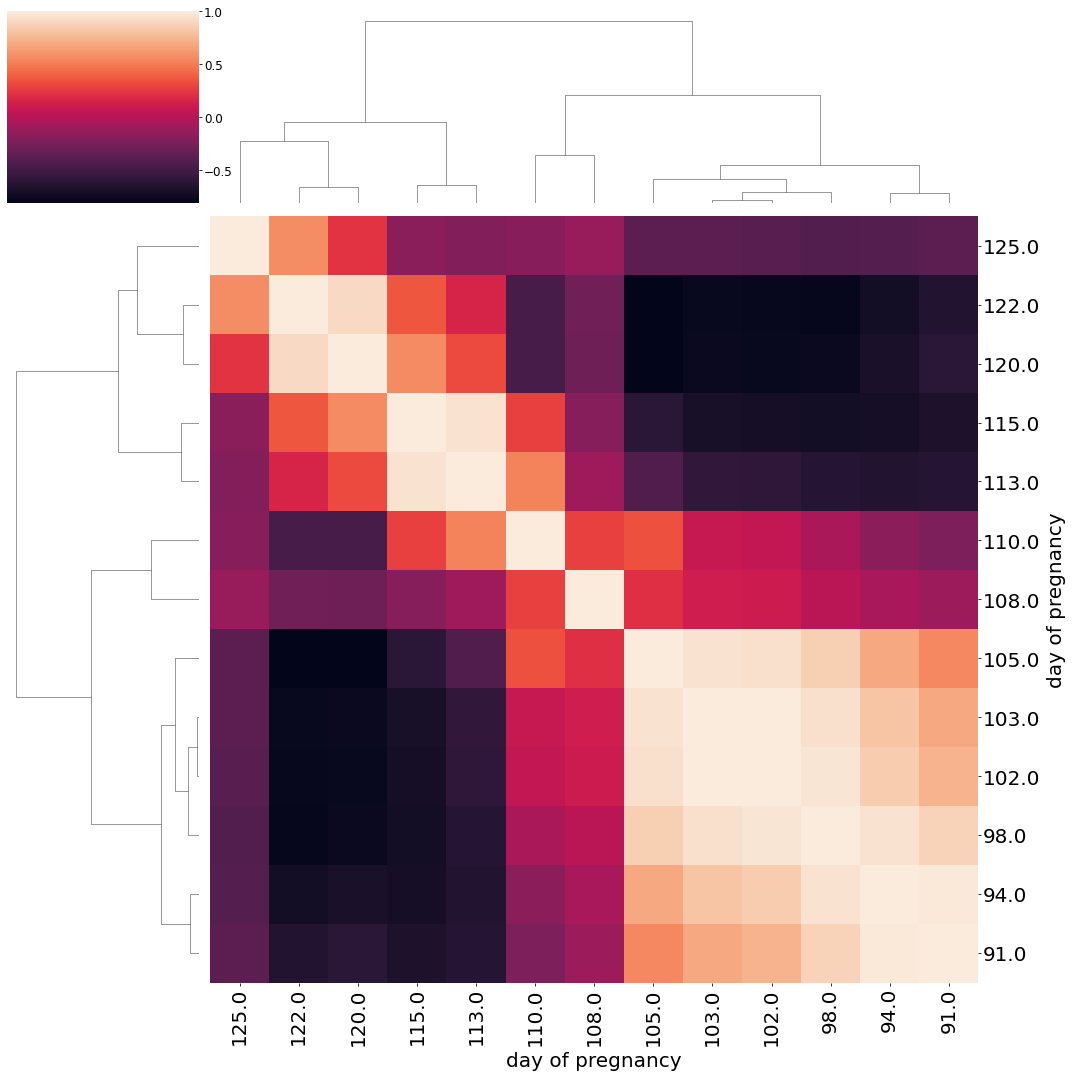

In [16]:
df = pd.DataFrame(attr, index=adata_emb.obs_names)
df = df.iloc[:, 32:]
df["day_of_pregnancy"] = [key[2] for key in keys]
df_agg = df.groupby("day_of_pregnancy").mean().T
linkage = hc.linkage(df_agg.corr(), metric="euclidean", method='complete', optimal_ordering=True)
h = sns.clustermap(df_agg.corr(), row_linkage=linkage, col_linkage=linkage, yticklabels=1, xticklabels=1, figsize=(15, 15))
h.ax_heatmap.set_yticklabels(h.ax_heatmap.get_yticklabels(), rotation=0, fontsize=20)
h.ax_heatmap.set_xticklabels(h.ax_heatmap.get_xticklabels(), rotation=90, fontsize=20)
h.ax_heatmap.set_ylabel("day of pregnancy", fontsize=20)
h.ax_heatmap.set_xlabel("day of pregnancy", fontsize=20)
plt.savefig(
        FIG_DIR_LCL + "embedding_cluster_age.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
plt.tight_layout()
plt.show()

In [30]:
adata_emb.obs["tissue"] = adata_emb.obs["tissue"].astype("category")
adata_emb.obs["cell_type"] = adata_emb.obs["cell_type"].astype("category")
adata_emb.obs["day_of_pregnancy"] = adata_emb.obs["day_of_pregnancy"].astype("category")
adata_emb.obs["day_of_pregnancy_cont"] = adata_emb.obs["day_of_pregnancy"].copy().astype(np.float16)

In [18]:
idx = []
for ti, tissue in enumerate(adata_emb.obs["tissue"].cat.categories):
    cts = atac[atac.obs["tissue"].isin([tissue])].obs["cell_type"].unique()
    
    idx.append(list(np.where((adata_emb.obs["tissue"].isin([tissue])) & (adata_emb.obs["cell_type"].isin(cts)))[0]))

In [19]:
adata_emb = adata_emb[np.concatenate(idx)]

In [20]:
sc.pp.pca(adata_emb)
sc.pp.neighbors(adata_emb, use_rep="X")
sc.tl.umap(adata_emb)

In [29]:
# adata_emb.obs["day_of_pregnancy_cont"].astype(np.float16)

del adata_emb.uns["day_of_pregnancy_cont_colors"]

In [32]:
palletes = {
    "tissue":  [atac.uns["tissue_colors"][np.where(atac.obs["tissue"].cat.categories == cat)[0][0]] for cat in adata_emb.obs["tissue"].cat.categories],                                
    "cell_type": [atac.uns["cell_type_colors"][np.where(atac.obs["cell_type"].cat.categories == cat)[0][0]] for cat in adata_emb.obs["cell_type"].cat.categories],                                
    "day_of_pregnancy": [atac.uns["day_of_pregnancy_cat_colors"][np.where(atac.obs["day_of_pregnancy_cat"].cat.categories == cat)[0][0]] for cat in adata_emb.obs["day_of_pregnancy"].cat.categories],  
    }

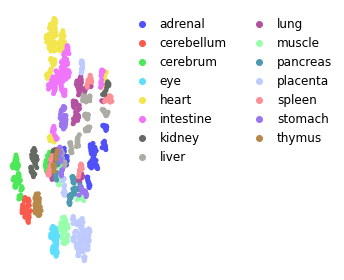

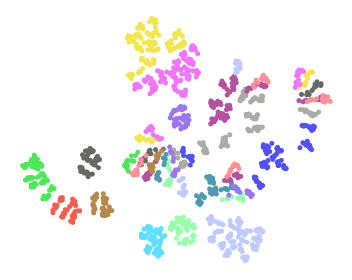

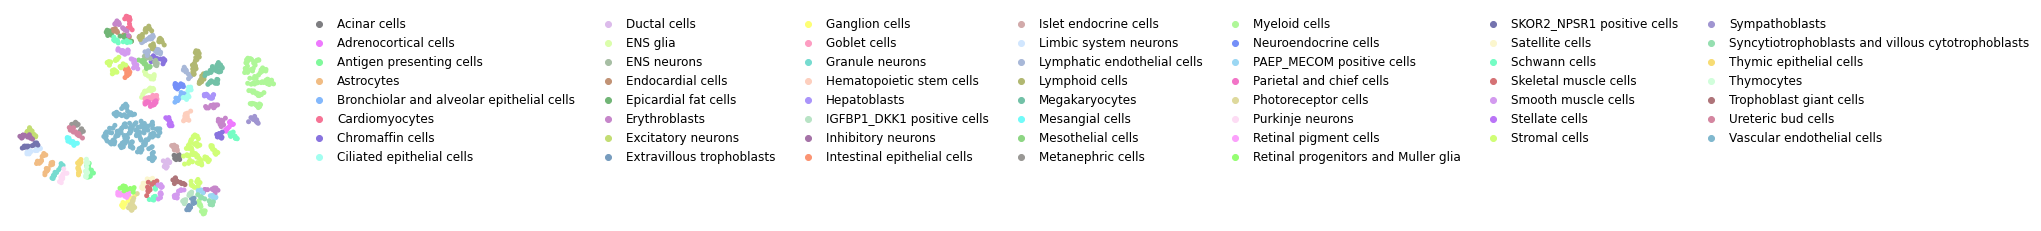

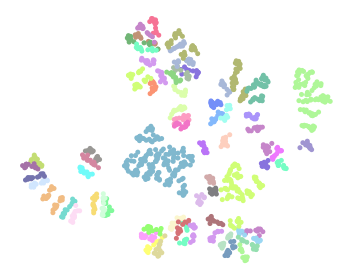

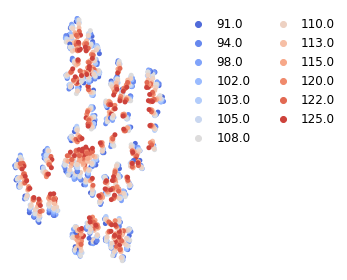

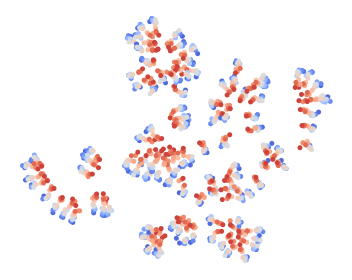

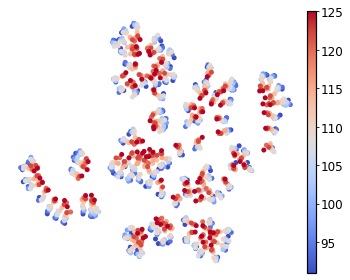

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


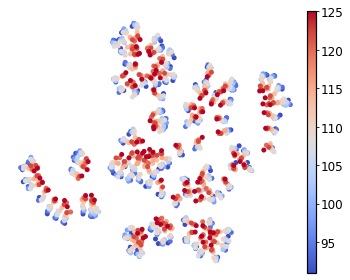

In [35]:
for c in ["tissue", "cell_type", "day_of_pregnancy", "day_of_pregnancy_cont"]: 
    
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))

    if c == "day_of_pregnancy_cont":
        sc.pl.umap(
                adata_emb,
                color=[c],
                ax=axs,
                show=False,
                size=100,
                cmap=sns.color_palette("coolwarm", as_cmap=True),
            )

    else:
        sc.pl.umap(
            adata_emb,
            color=[c],
            ax=axs,
            show=False,
            size=100,
            palette=palletes[c],
        )
        plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', ncols=np.ceil(len(palletes[c])/8))

    
    axs.set_title("")
    axs.set_axis_off()
    plt.savefig(
        FIG_DIR_LCL + f"embedding_{c}_umap.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 1, figsize=(5, 4))
    if c == "day_of_pregnancy_cont":
        sc.pl.umap(
                adata_emb,
                color=[c],
                ax=axs,
                show=False,
                size=100,
                cmap=sns.color_palette("coolwarm", as_cmap=True),
            )

    else:
        sc.pl.umap(
            adata_emb,
            color=[c],
            ax=axs,
            show=False,
            size=100,
            palette=palletes[c],
        )

    
    axs.set_title("")
    axs.set_axis_off()
    plt.legend().remove()
    plt.savefig(
        FIG_DIR_LCL + f"embedding_{c}_umap_nleg.png",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )
    plt.tight_layout()
    plt.show()
    

In [36]:
for i, ct in enumerate(adata_emb.obs["cell_type"].cat.categories):
    adata_emb.obs[ct] = None
    adata_emb.obs.loc[adata_emb.obs["cell_type"].isin([ct]), ct] = ct
    adata_emb.obs[ct] = adata_emb.obs[ct].astype("category")
    adata_emb.uns[f"{ct}_colors"] = [adata_emb.uns["cell_type_colors"][i]]
    

    adata_emb.obs[f"{ct}_tissue"] = None
    adata_emb.obs.loc[adata_emb.obs["cell_type"].isin([ct]), f"{ct}_tissue"] = adata_emb[adata_emb.obs["cell_type"].isin([ct])].obs["tissue"]
    adata_emb.obs[f"{ct}_tissue"] = adata_emb.obs[f"{ct}_tissue"].astype("category")
    adata_emb.uns[f"{ct}_tissue_colors"] = [adata_emb.uns["tissue_colors"][np.argwhere(adata_emb.obs["tissue"].cat.categories == ti)[0][0]] for ti in adata_emb.obs[f"{ct}_tissue"].cat.categories]



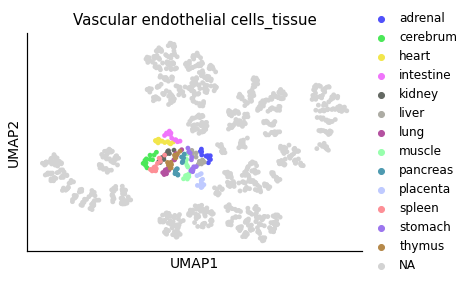

In [37]:
sc.pl.umap(adata_emb,
           color="Vascular endothelial cells_tissue")

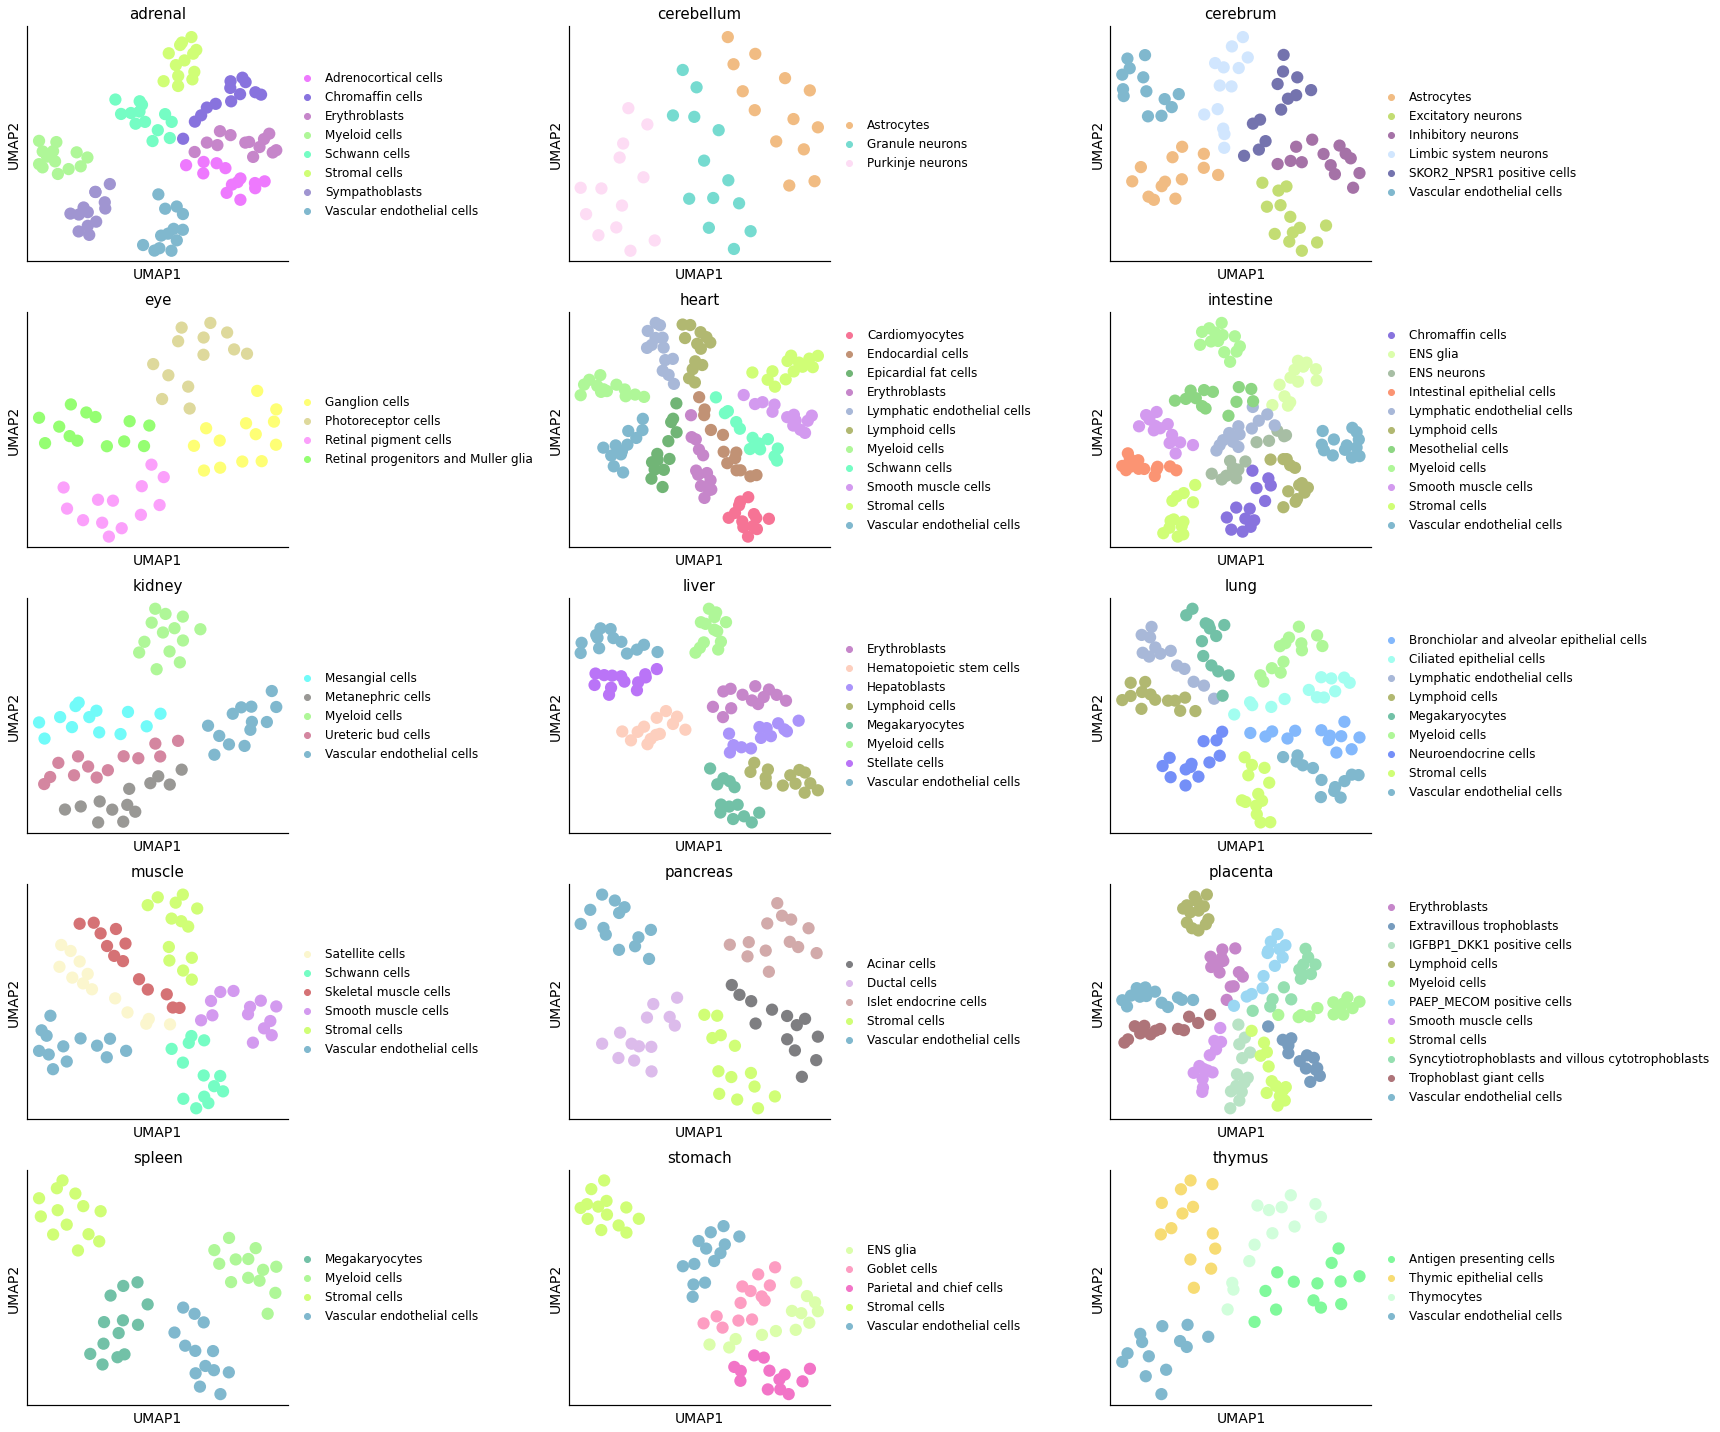

In [38]:
fig, axs = plt.subplots(5, 3, figsize=(8*3, 4*5))

for ti, tissue in enumerate(adata_emb.obs["tissue"].cat.categories):
    i,j = np.unravel_index(ti, (5,3))
    cts = atac[atac.obs["tissue"].isin([tissue])].obs["cell_type"].unique()
    adata_c = adata_emb[(adata_emb.obs["tissue"].isin([tissue])) & (adata_emb.obs["cell_type"].isin(cts))].copy()
    
    sc.pp.neighbors(adata_c, use_rep="X", n_neighbors=15)
    sc.tl.umap(adata_c)
    
    sc.pl.umap(
        adata_c,
        color="cell_type",
        ax=axs[i,j],
        show=False,
        size=600,
        # legend_loc="on data"
    )
    
    axs[i,j].set_title(tissue)
    # axs[i,j].set_axis_off()
    # plt.legend().remove()
    
plt.tight_layout()
plt.savefig(
    FIG_DIR_LCL + f"tissue_cell_type.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

### Compute predictions

In [39]:
cell_tissue = {}
cell_tissue_count = {}
for cell in atac.obs["cell_type"].cat.categories:
    cell_tissue[cell] = atac[atac.obs["cell_type"] == cell].obs["tissue"].cat.categories.tolist()
    cell_tissue_count[cell] = len(atac[atac.obs["cell_type"] == cell].obs["tissue"].cat.categories)

In [40]:
tissue_cell = {}
tissue_cell_count = {}
for tissue in atac.obs["tissue"].cat.categories:
    tissue_cell[tissue] = atac[atac.obs["tissue"] == tissue].obs["cell_type"].cat.categories.tolist()
    tissue_cell_count[tissue] = len(atac[atac.obs["tissue"] == tissue].obs["cell_type"].cat.categories)

#### `placenta` analysis

In [41]:
cell_type = "Vascular endothelial cells"
tissue = "placenta"
sample = "sample_26_placenta"

In [42]:
idx_source = np.where(
    (atac.obs["split_random"] == "train") & 
    (atac.obs["cell_type"] ==  cell_type) &
    (atac.obs["sample_name"] == sample)
)[0]

atac_source = atac[idx_source].copy()

In [43]:
adata_preds = model.compute_prediction_adata(
    atac,
    atac_source,
    target_attributes=["cell_type"], 
)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:01,  1.50it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


4it [00:01,  2.97it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


5it [00:01,  2.72it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


6it [00:03,  1.74it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


7it [00:03,  2.29it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


10it [00:03,  4.65it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


12it [00:03,  5.94it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


14it [00:06,  1.69it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


15it [00:07,  1.49it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


18it [00:07,  2.58it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


21it [00:08,  3.02it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


23it [00:08,  3.54it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


24it [00:08,  3.35it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


27it [00:09,  5.14it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


29it [00:09,  4.68it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


30it [00:09,  4.78it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


32it [00:10,  3.22it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


33it [00:11,  2.90it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


37it [00:11,  5.40it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


40it [00:11,  7.29it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


42it [00:11,  8.03it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


44it [00:11,  8.16it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


46it [00:12,  8.07it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


48it [00:13,  3.00it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


49it [00:14,  3.29it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


51it [00:14,  3.46it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


52it [00:14,  3.78it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


53it [00:15,  3.87it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


54it [00:15,  3.44it/s]


In [44]:
adata_preds_cell_type = adata_preds[(adata_preds.obs["cell_type"].isin(tissue_cell[tissue]))]

In [45]:
adata_preds_cell_type.layers["counts"] = adata_preds_cell_type.X
sc.pp.normalize_per_cell(adata_preds_cell_type, counts_per_cell_after=1e4)
sc.pp.log1p(adata_preds_cell_type)
sc.pp.pca(adata_preds_cell_type)
sc.pp.neighbors(adata_preds_cell_type)
sc.tl.umap(adata_preds_cell_type)

In [46]:
adata_preds_cell_type.uns["cell_type_colors"] = [adata_emb.uns["cell_type_colors"][np.argwhere(adata_emb.obs["cell_type"].cat.categories == ci)[0][0]] for ci in adata_preds_cell_type.obs["cell_type"].cat.categories]

In [48]:
adata_preds_cell_type.uns["atac"] = atac.uns["atac"].copy()

In [49]:
ac.tl.rank_peaks_groups(adata_preds_cell_type, "cell_type")

In [50]:
adata_preds_cell_type.layers["X"] = adata_preds_cell_type.X.copy()
sc.pp.scale(adata_preds_cell_type)

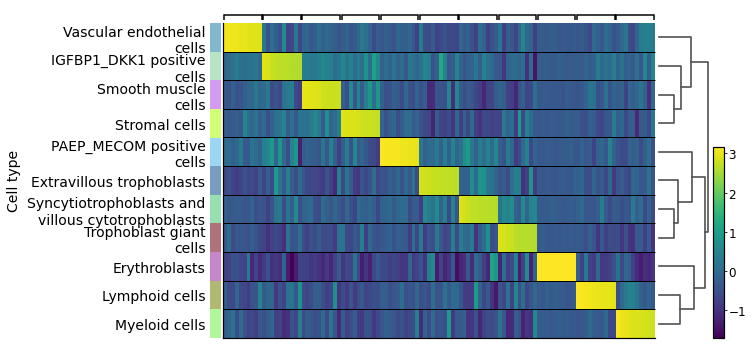

In [51]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
h = sc.pl.rank_genes_groups_heatmap(adata_preds_cell_type, return_fig=True, show=False)
arr = []
h["groupby_ax"].set_ylabel("Cell type")
for label in h["groupby_ax"].get_yticklabels():
    if len(label.get_text().split(" ")) > 2:
        label.set_text(" ".join(label.get_text().split(" ")[:2]) + "\n" + " ".join(label.get_text().split(" ")[2:]))
    arr.append(label)

h["groupby_ax"].set_yticklabels(arr, fontsize=14)
for txt in h["gene_groups_ax"].texts:
    txt.set_text(" ")
    # if len(txt.get_text().split(" ")) > 2:
    #     txt.set_text(" ".join(txt.get_text().split(" ")[:2]) + "\n" + " ".join(txt.get_text().split(" ")[2:]))
plt.tight_layout()
plt.savefig(
    FIG_DIR_LCL + f"cell_type_peaks.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

In [52]:
marker_peaks = {}
marker_pvals = {}
n_peaks = 500
pval_cutoff = 0.05
for ct in adata_preds_cell_type.obs["cell_type"].cat.categories:
    
    select1 = adata_preds_cell_type.uns["rank_genes_groups"]["pvals_adj"][ct] < pval_cutoff
    select2 = adata_preds_cell_type.uns["rank_genes_groups"]["scores"][ct] > 0
    select = np.where(select1 & select2)[0]
    marker_peaks[ct] = adata_preds_cell_type.uns["rank_genes_groups"]["names"][ct][select]
    marker_pvals[ct] = adata_preds_cell_type.uns["rank_genes_groups"]["pvals_adj"][ct][select]

    print(f"for {ct} found {len(select)} markers")
    peaks_enriched_fname = OUTPUT_DIR_LCL + f"peaks_{ct}.bed"
    with open(peaks_enriched_fname, 'w') as f:
        f.write(f"#Bed {tissue}\n#Region\tStart pos.\tEnd pos.\n")
        for peak in marker_peaks[ct]:
            f.write(peak.replace("-", "\t") + "\n")


for Erythroblasts found 3747 markers
for Extravillous trophoblasts found 3980 markers
for IGFBP1_DKK1 positive cells found 5487 markers
for Lymphoid cells found 4112 markers
for Myeloid cells found 4186 markers
for PAEP_MECOM positive cells found 5121 markers
for Smooth muscle cells found 4818 markers
for Stromal cells found 4742 markers
for Syncytiotrophoblasts and villous cytotrophoblasts found 4549 markers
for Trophoblast giant cells found 4084 markers
for Vascular endothelial cells found 4788 markers


In [53]:
peaks_enriched_fname = OUTPUT_DIR_LCL + f"peaks_bg.bed"
with open(peaks_enriched_fname, 'w') as f:
    f.write(f"#Bed {tissue}\n#Region\tStart pos.\tEnd pos.\n")
    for peak in adata_preds_cell_type.var_names:
        f.write(peak.replace("-", "\t") + "\n")

### Run `GREAT` analysis

Using the online API [here](http://great.stanford.edu/public/html/index.php) set _Species Assembly_ = Human: GRCh37 (UCSC hg19, Feb. 2009) and upload the "peaks_Vascular endothelial cells.bed" as _Test regions_ and the "peaks_bg.bed" as _Background regions_. 

Download the results as "greatExportAll_vascular.tsv".

In [54]:
df_great = pd.read_csv(OUTPUT_DIR_LCL + "greatExportAll_vascular.tsv", delimiter="\t")
df_great = df_great.iloc[:500, :]
df_great["GO term"] = df_great["Desc"].copy()

GO_terms = []
for str_ in df_great["GO term"]:
    list_ = re.findall(r"[\w]+", str_)
    if len(str_) > 30:
        idx_ = int(len(list_) / 2 - 1)
        list_[idx_] = list_[idx_] + "\n" + list_[idx_ + 1]
        list_.pop(idx_ + 1)
        str_ = " ".join(list_)
    GO_terms.append(str_.lower().capitalize())

df_great.iloc[:, -1] = GO_terms

In [55]:
df_great["$-log_{10}(p_{hyper})$"] = np.round(-1 * np.log10(df_great["HyperP"]), 1)
df_great["Fold enrichment"] = np.round(df_great["RegionFoldEnrich"],  decimals=2)
df_great["Gene fraction"] = np.round(df_great["NumFgGenesHit"] / df_great["TotalGenes"], decimals=2)

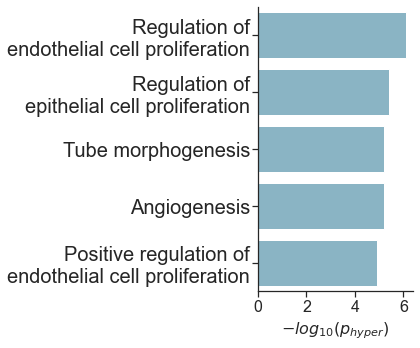

In [57]:
size = 5
fig, axs = plt.subplots(figsize=(size+1, size))
sns.set_theme(style="white")
plt.rcParams["xtick.bottom"] = True
plt.rcParams["ytick.left"] = True

x_val = "$-log_{10}(p_{hyper})$"
df_great_srt = df_great.sort_values(by = x_val, ascending = False)
sns.barplot(
    data=df_great_srt.iloc[:5, :],
    x=x_val,
    y="GO term",
    color = adata_preds_cell_type.uns["cell_type_colors"][-1],
    ax=axs,
)

sns.despine(offset=0, trim=False)

# axs.set_xlim(0, .3)
plt.yticks(fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel("")
plt.xlabel(r"$-log_{10}(p_{hyper})$", fontsize=16)

plt.tight_layout()
plt.savefig(
    FIG_DIR_LCL + "go_dots_vascular_leg.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
plt.show()